# Loan approval prediction

This project analyzes a loan approval dataset to understand key factors influencing approval decisions, explore potential biases and build predictive models for loan approval. 

$\textbf{Target variable:}$ loan_status (Approved / Rejected).

$\textbf{Main steps in this notebook:}$

- Load and inspect the dataset.
- Perform data cleaning and handle anomalies.
- Add a small feature to capture missing/unknown residential asset information.
- Perform exploratory data analysis.


## Data Overview

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [ ]:
# Loading the dataset
df = pd.read_csv("loan_approval_dataset.csv")
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [ ]:
# Checking the shape of the dataset
df.shape

(4269, 13)

In [ ]:
# Checking for missing values
df.isna().sum()

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

In [ ]:
# Checking the data types
df.dtypes

loan_id                       int64
 no_of_dependents             int64
 education                   object
 self_employed               object
 income_annum                 int64
 loan_amount                  int64
 loan_term                    int64
 cibil_score                  int64
 residential_assets_value     int64
 commercial_assets_value      int64
 luxury_assets_value          int64
 bank_asset_value             int64
 loan_status                 object
dtype: object

In [ ]:
# Removing leading spaces in column names.
df.columns = df.columns.str.strip()

### Data Quality & Cleaning

`loan_id` is only an identifier and should not be used as a predictive feature.

In [136]:
df.drop(["loan_id"], axis = 1, inplace = True)

The target column is `loan_status`.

In [137]:
df['loan_status'] = df['loan_status'].map({' Approved': 1, ' Rejected':0})
df['loan_status'].value_counts()

loan_status
1    2656
0    1613
Name: count, dtype: int64

In [138]:
df.describe()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269.000000
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,0.622160
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,0.484904
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,0.000000
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,1.000000
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,1.000000
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07,1.000000


Noticed that some rows have `residential_assets_value = -100000`, which is not realistic. This is likely a placeholder for missing/unknown data.

Approach:
1. Create a new categorical feature that marks whether residential assets are:
    - Unknown (placeholder)
    - None (0)
    - Owner (>0)
2. Replace the placeholder -100000 with the median of valid values (>=0), so the numeric scale stays reasonable.

In [139]:
df[df['residential_assets_value'] == df['residential_assets_value'].min()].head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
59,4,Not Graduate,Yes,5500000,18200000,16,797,-100000,4900000,18600000,4800000,1
196,4,Not Graduate,Yes,400000,1500000,2,669,-100000,600000,900000,500000,1
559,2,Graduate,Yes,200000,500000,6,885,-100000,0,300000,200000,0
702,4,Graduate,Yes,6300000,23900000,6,899,-100000,11400000,20600000,6700000,1
737,2,Graduate,Yes,900000,2500000,16,458,-100000,100000,3200000,1100000,0


In [140]:
# How many placeholder values?
len(df[df['residential_assets_value'] == df['residential_assets_value'].min()])

28

In [141]:
# How much of the dataset contains placeholder values?
len(df[df['residential_assets_value'] == df['residential_assets_value'].min()]) / df.shape[0]

0.006558913094401499

Checking if and how many rows have a residential asset value of 0 which most likely means that the borrower does not have any residential property. In terms of loan approval its riskier because there is no house for backup if the loan is not paid. 

In [142]:
len(df[df['residential_assets_value'] == 0])

45

Checking if there are any more anomalies in the dataset. If the number is more than 28, then its worth investigating.

In [143]:
len(df[df['residential_assets_value'] < 0])

28

In [144]:
def get_asset_status(row):
    if row['residential_assets_value'] == -100000:
        return 'Unknown'
    elif row['residential_assets_value'] == 0:
        return 'No_Res_Assets'
    else:
        return 'Has_Res_Assets'

df['res_asset_status'] = df.apply(get_asset_status, axis = 1)

I chose not to delete these records because they contained valuable signals in other areas, such as commerical assets. I implemented a hybrid approach. I imputed the missing values with the median to keep the numerical scale consistent and created a new categorical feature to allow the model to distinguish between non-owners and unknown data points.

In [ ]:
# Impute placeholder with median of valid values.
res_median = df[df['residential_assets_value'] >= 0]['residential_assets_value'].median()
df['residential_assets_value'] = df['residential_assets_value'].replace(-100000, res_median)

In [101]:
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,res_asset_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1,Has_Res_Assets
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0,Has_Res_Assets
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0,Has_Res_Assets
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0,Has_Res_Assets
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0,Has_Res_Assets


### Data visualization

interval columns not set, guessing: [' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']


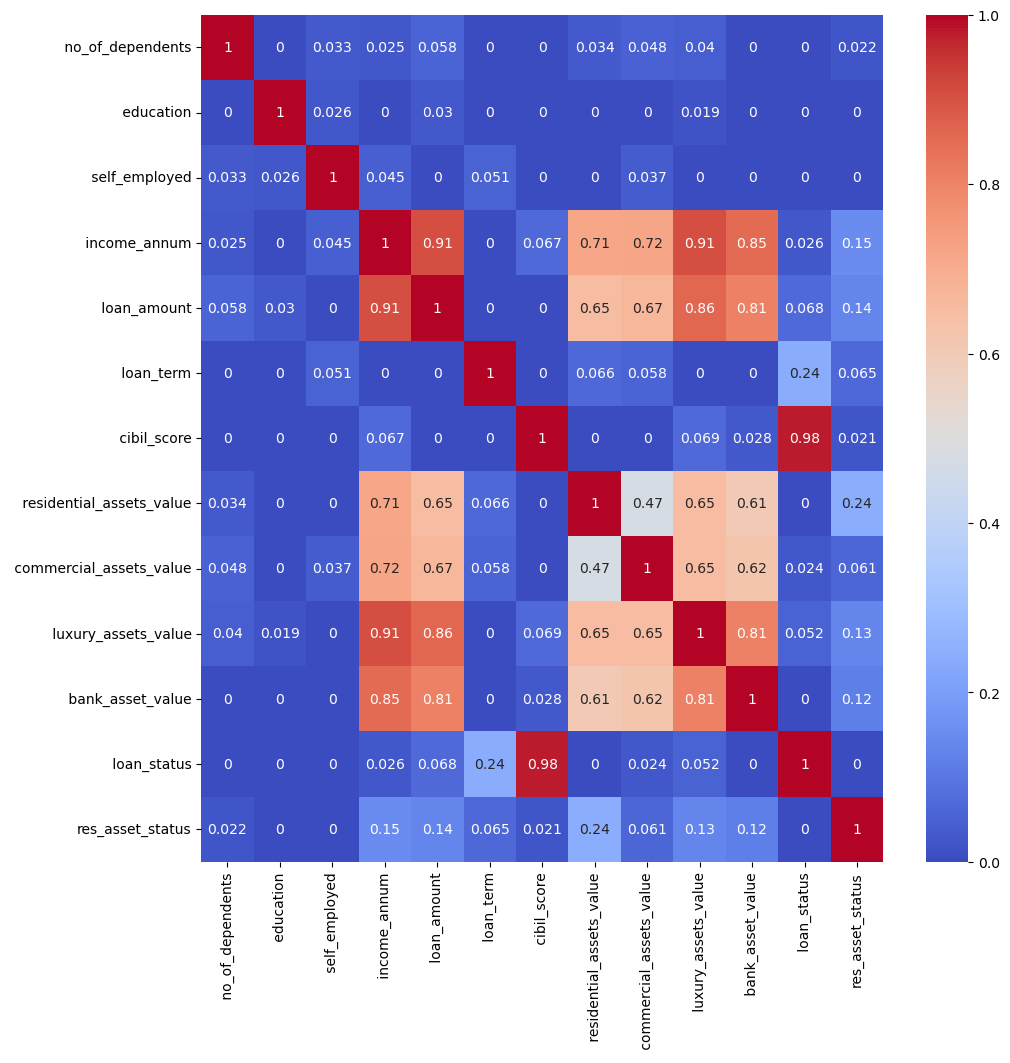

In [105]:
import phik
from phik import report
phik_matrix = df.phik_matrix()
plt.figure(figsize = (11,11))
sns.heatmap(phik_matrix, annot = True, cmap = "coolwarm")
plt.show()

The correlation shows a very strong relationship between `cibil_score` and `loan_status` (correlation 0.98). 

This indicates that credit score is the dominant factor in loan approval decisions. In practice, this is realistic, as lenders heavily rely on credit scores when evaluating applications. 

However, this also means that any predictive model may archieve high accuracy mainly by learning the credit score threshold, while other features play a secondary role.

To better understand the role of credit score, models will later be trained both with and without `cibil_score`. This allows seperating overall predictive accuracy from the contribution of other applicant charecteristics.

<Axes: >

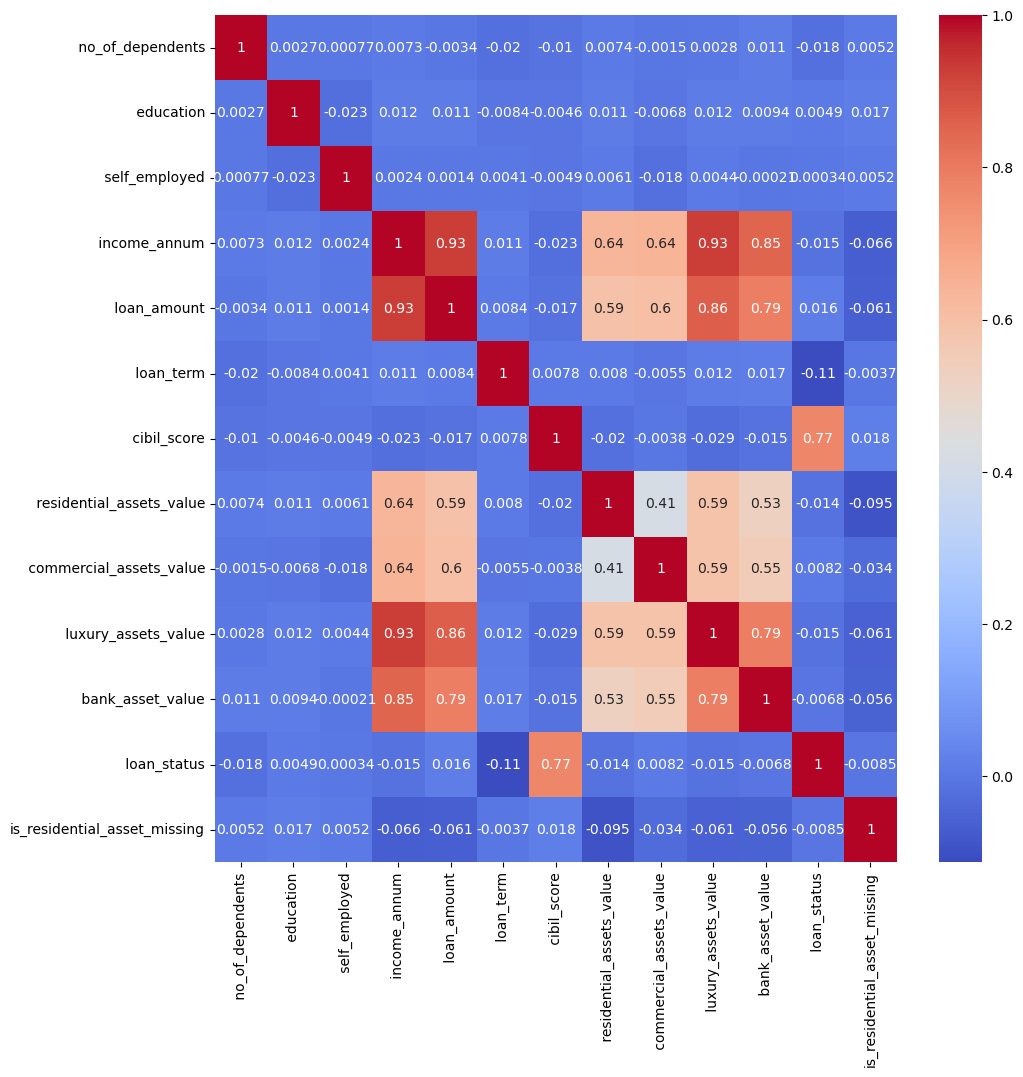

In [34]:
plt.figure(figsize=(11,11))
sns.heatmap(df.corr(), annot=True, cmap = "coolwarm")

## Data visualization

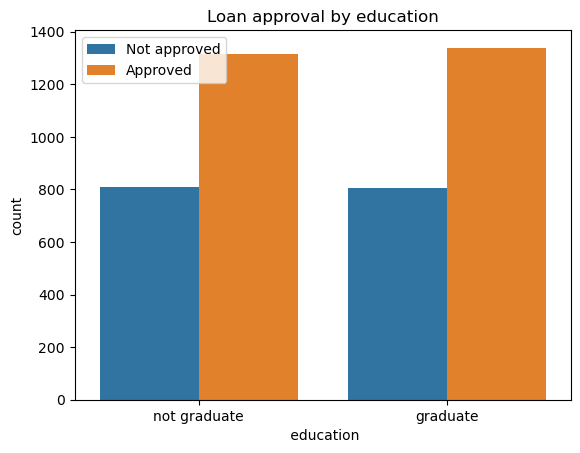

In [ ]:
sns.countplot(data = df, x = 'education', hue = 'loan_status')
plt.legend(["Not approved", "Approved"], loc = 'upper left')
plt.title("Loan approval by education")
plt.xticks([0,1], ["Not graduate", "Graduate"])
plt.show()

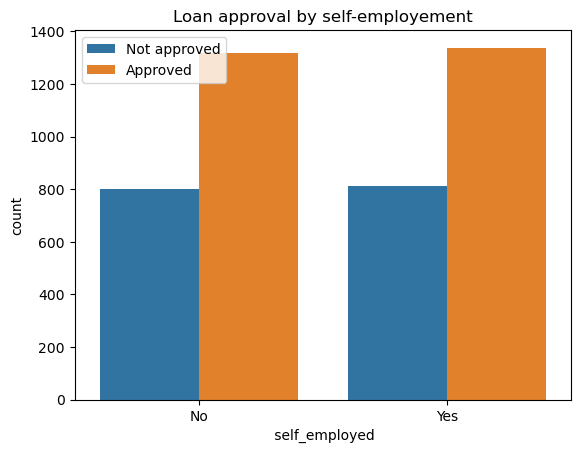

In [ ]:
sns.countplot(data = df, x = 'self_employed', hue = 'loan_status')
plt.legend(["Not approved", "Approved"], loc = 'upper left')
plt.title("Loan approval by self-employement")
plt.xticks([0,1], ["No", "Yes"])
plt.show()

<Axes: xlabel=' loan_status', ylabel=' cibil_score'>

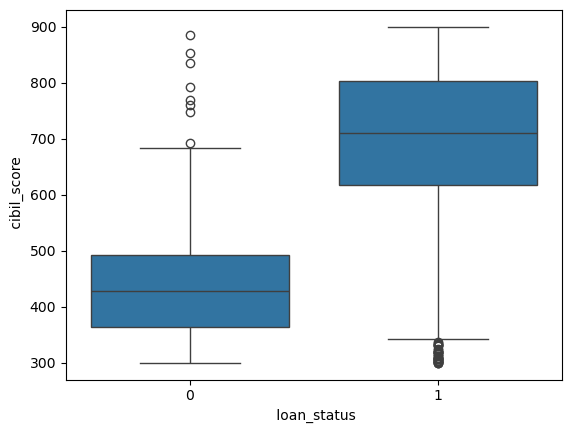

In [ ]:
sns.boxplot(data = df, x = 'loan_status', y = 'cibil_score')


## Model training

### Encoding categorical variables (One-Hot Encoding)

Machine learning models need numerical input.

Instead of manually mapping categories to 0/1, I use One-Hot Encoding:
- It creates a seperate column for each category.
- This avoids accodentally giving categories an artificial "order".

In [ ]:
X = df.drop(columns = ['loan_status'])
y = df['loan_status']

categorical_cols = ['education', 'self_employed', 'res_asset_status']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

X_encoded = preprocess.fit_transform(X)
X_encoded.shape

In [ ]:

X_train_all, X_test_all, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [111]:
# model_rf = RandomForestClassifier()
# model_rf.fit(X_train_all, y_train)
# prediction_rf = model_rf.predict(X_test_all)
# print(f'Accuracy: {accuracy_score(y_test, prediction_rf) * 100:.2f}%')

In [109]:
# model_xb = XGBClassifier()
# model_xb.fit(X_train_all, y_train)
# prediction_xb = model_xb.predict(X_test_all)
# acc_all = accuracy_score(y_test, prediction_xb)

# model_xb_no = XGBClassifier()
# model_xb_no.fit(X_train_no, y_train)
# prediction_xb_no = model_xb_no.predict(X_test_no)
# acc_no = accuracy_score(y_test, prediction_xb_no)
# print(f"Accuracy with CIBIL: {acc_all}")
# print(f"Accuracy without CIBIL: {acc_no}")

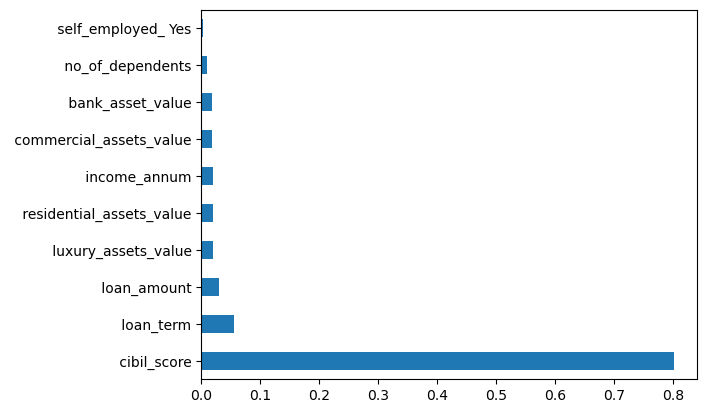

In [ ]:
# import matplotlib.pyplot as plt

# feat_importances = pd.Series(model.feature_importances_, index = X.columns)
# feat_importances.nlargest(10).plot(kind = 'barh')
# plt.show()

# SHAP

In [ ]:
# import shap 
# explainer = shap.Explainer(model, X_test)
# shap_values = explainer(X_test)
# shap.plots.waterfall(shap_values[0])